<a href="https://colab.research.google.com/github/Mohitjain1708/image_steganography/blob/main/image_steganography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install pillow ipywidgets cryptography --quiet

In [60]:
from google.colab import files
from PIL import Image
import io
from IPython.display import display
import ipywidgets as widgets
import numpy as np
from cryptography.fernet import Fernet

In [76]:

def generate_key():
    return Fernet.generate_key()

def encrypt_message(msg, key):
    return Fernet(key).encrypt(msg.encode()).decode()

def decrypt_message(msg, key):
    return Fernet(key).decrypt(msg.encode()).decode()

def text_to_binary(text):
    return ''.join(format(ord(c), '08b') for c in text)

def binary_to_text(binary):
    return ''.join(chr(int(binary[i:i+8], 2)) for i in range(0, len(binary), 8))

def encode_image(img, message):
    binary = text_to_binary(message + "#####")
    array = np.array(img)
    flat_data = array.flatten()

    if len(binary) > len(flat_data):
        raise ValueError(f"Message too long. Image can hold ~{len(flat_data)//8} characters. Message requires {len(binary)//8} characters.")

    for i in range(len(binary)):
        flat_data[i] = (int(flat_data[i]) & ~1) | int(binary[i])

    reshaped = flat_data.reshape(array.shape)
    return Image.fromarray(np.uint8(reshaped))

def decode_image(img):
    data = np.array(img).flatten()
    bits = ''.join([str(int(b) & 1) for b in data])
    chars = [bits[i:i+8] for i in range(0, len(bits), 8)]

    message = ''
    for c in chars:
        try:
            char = chr(int(c, 2))
        except:
            break
        message += char
        if message.endswith("#####"):
            return message[:-5]
    return "No hidden message found or image was corrupted."

In [77]:

def run_steganography():
    print("Upload an image (recommended: PNG, at least 100x100 pixels):")
    uploaded = files.upload()
    for fname in uploaded:
        image = Image.open(io.BytesIO(uploaded[fname])).convert("RGB")
        display(image)

    action = widgets.ToggleButtons(options=["Encode", "Decode"], description="Action:")
    output = widgets.Output()
    display(action, output)

    def on_action_change(change):
        output.clear_output()
        with output:
            if change['new'] == "Encode":
                msg_box = widgets.Textarea(description="Message:", layout={'width': '100%', 'height': '100px'})
                encrypt_checkbox = widgets.Checkbox(value=False, description="Encrypt message?")
                encode_btn = widgets.Button(description="Encode and Download")
                key = generate_key()

                display(widgets.VBox([msg_box, encrypt_checkbox, encode_btn]))

                def on_click(b):
                    try:
                        msg = msg_box.value.strip()
                        if not msg:
                            print("Enter a message to encode.")
                            return

                        if encrypt_checkbox.value:
                            msg = encrypt_message(msg, key)
                            print("Encrypted message:", msg)
                            print("Encryption Key:", key.decode())

                        stego = encode_image(image, msg)
                        stego.save("stego_image.png")
                        print("Image saved as stego_image.png")
                        files.download("stego_image.png")

                    except Exception as e:
                        print("Error:", e)

                encode_btn.on_click(on_click)

            elif change['new'] == "Decode":
                key_box = widgets.Text(description="Decryption Key (optional):", layout={'width': '100%'})
                decode_btn = widgets.Button(description="Decode Message")
                display(widgets.VBox([key_box, decode_btn]))

                def on_decode_click(b):
                    try:
                        msg = decode_image(image)
                        print("🔍 Raw decoded message:", msg)
                        if key_box.value.strip():
                            try:
                                msg = decrypt_message(msg, key_box.value.strip().encode())
                                print("Decrypted Message:")
                                print(msg)
                            except Exception as decryption_error:
                                import traceback
                                print("Decryption failed. Details:")
                                traceback.print_exc()
                        else:
                            print("Decoded Message:")
                            print(msg)
                    except Exception as decode_error:
                        import traceback
                        print("Error during decoding. Details:")
                        traceback.print_exc()

                decode_btn.on_click(on_decode_click)

    action.observe(on_action_change, names="value")

Upload an image (recommended: PNG, at least 100x100 pixels):


Saving image.jpg to image.jpg


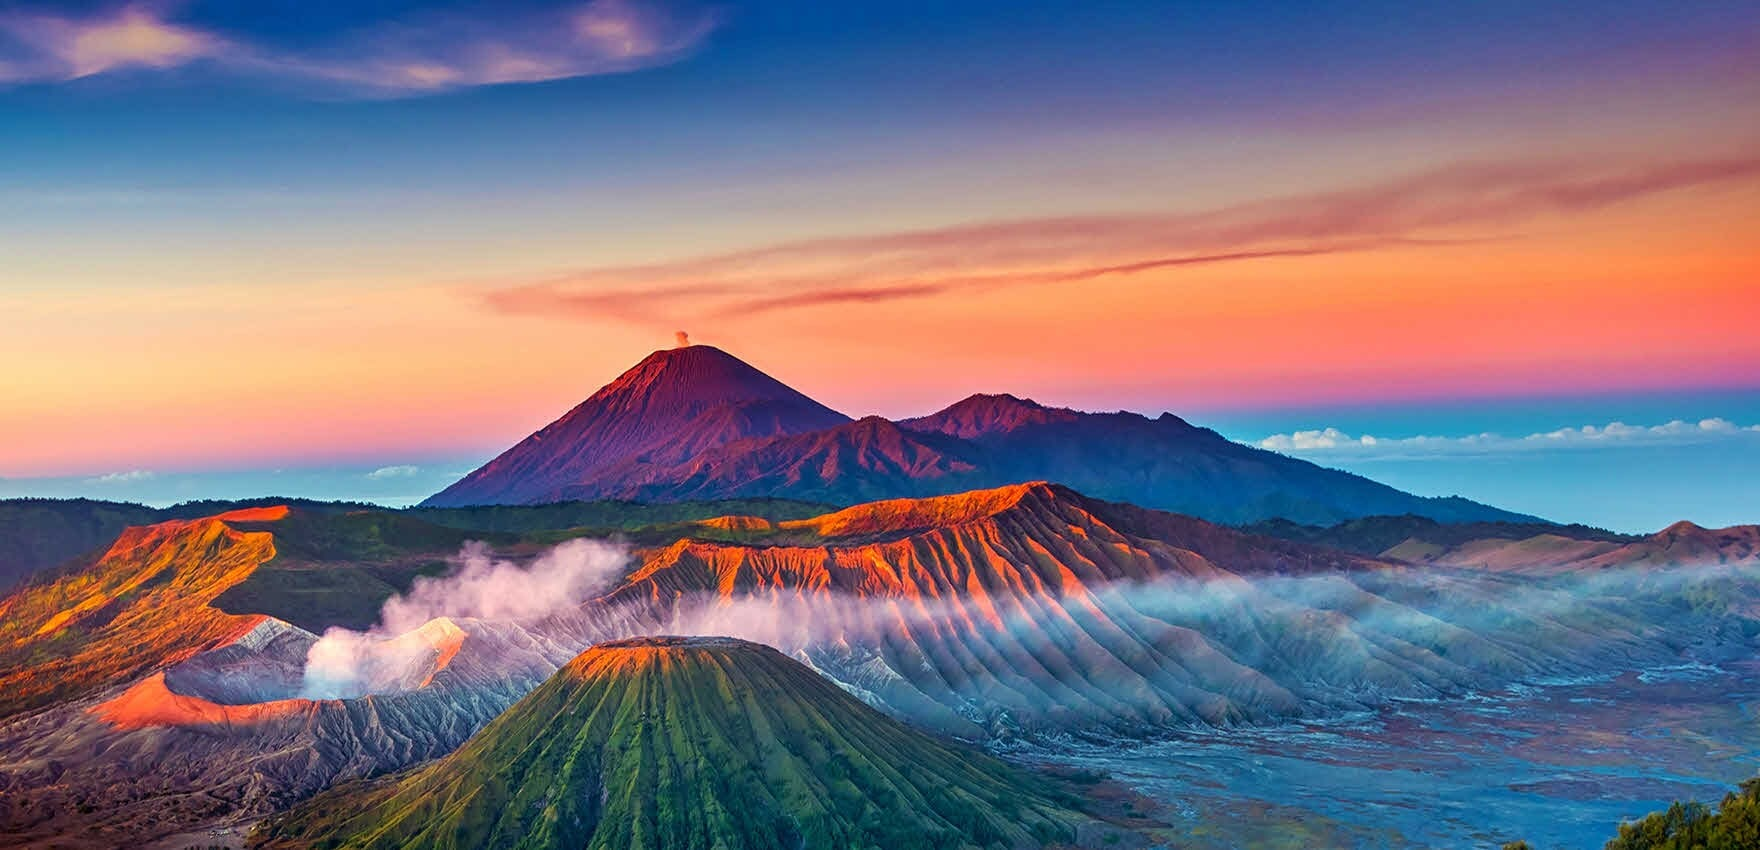

ToggleButtons(description='Action:', options=('Encode', 'Decode'), value='Encode')

Output()

Encrypted message: gAAAAABoWvieS3UG2P2pT-0JXPOK5zjZobUVV65rhbC5e2rTIikjMa1w9BxNDjC25gPZpNbfLbhkP4Hehp0wRzE04-nwHwa9n3P1rIVtLExBz992q6O0JQmdR7mwKheCcgt8o9r_xNtQ8ASVQYNcEWdhRTOElZnNedtF811QDVxSy03oIqIWoCqkkdFFUU9Q_jnTs1ZXEseE
Encryption Key: KiEj64Q_aE3V2BHNb-4KX2JnFD93P9OK5js4BMG8PRQ=
Image saved as stego_image.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
run_steganography()

Upload an image (recommended: PNG, at least 100x100 pixels):


Saving stego_image.png to stego_image (1).png


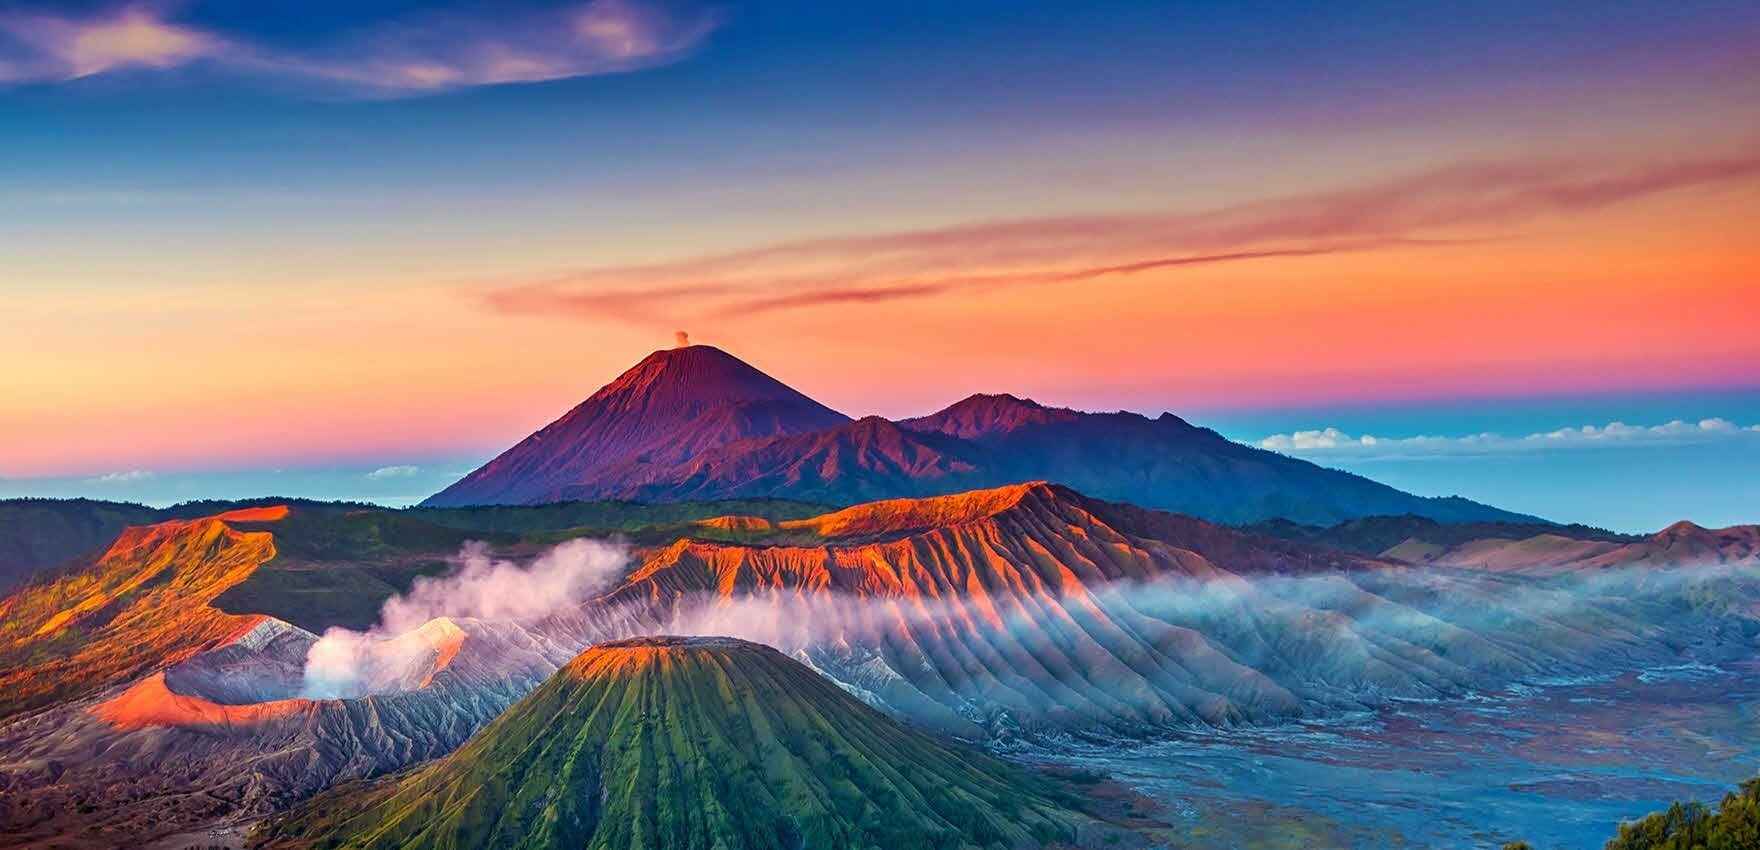

ToggleButtons(description='Action:', options=('Encode', 'Decode'), value='Encode')

Output()

Decrypted Message:
"""Agent 47,
Proceed to checkpoint delta at 2300 hrs.
Avoid surveillance.
Code: red-fox."""


In [73]:
run_steganography()